# Homework 1

Least-squares, regularization, QR, and SVD

-   Names: Ethan Wong 
-   CWLs: ethnwng

$$
\def\argmin{\operatorname*{argmin}}
\def\argmax{\operatorname*{argmax}}
\def\Ball{\mathbf{B}}
\def\bmat#1{\begin{bmatrix}#1\end{bmatrix}}
\def\Diag{\mathbf{Diag}}
\def\half{\tfrac12}
\def\int{\mathop{\rm int}}
\def\ip#1{\langle #1 \rangle}
\def\maxim{\mathop{\hbox{\rm maximize}}}
\def\maximize#1{\displaystyle\maxim_{#1}}
\def\minim{\mathop{\hbox{\rm minimize}}}
\def\minimize#1{\displaystyle\minim_{#1}}
\def\norm#1{\|#1\|}
\def\Null{{\mathbf{null}}}
\def\proj{\mathbf{proj}}
\def\R{\mathbb R}
\def\Re{\mathbb R}
\def\Rn{\R^n}
\def\rank{\mathbf{rank}}
\def\range{{\mathbf{range}}}
\def\sign{{\mathbf{sign}}}
\def\span{{\mathbf{span}}}
\def\st{\hbox{\rm subject to}}
\def\T{^\intercal}
\def\textt#1{\quad\text{#1}\quad}
\def\trace{\mathbf{trace}}
\def\xbar{\bar x}
$$

**Homework submission instructions**

 -   Due Friday, Jan 23 at 7 PM
 -   Follow Homework Submission instructions (located in About module) on Canvas.
 -   If you want TA feedback on your answer to a particular question (beyond your grade on the Emerging/Developing/Proficient scale), clearly indicate this in your answer to the question.



In [1]:
using Downloads
fname = "mlo_N2O_All.dat"
if !isfile(fname)
    Downloads.download("https://gml.noaa.gov/aftp/data/hats/n2o/insituGCs/CATS/hourly/mlo_N2O_All.dat", fname)
end


In [2]:
using CSV, DataFrames, DataFramesMeta, Statistics
df = CSV.read(fname, DataFrame, comment="#", normalizenames=true, delim=" ", ignorerepeated=true)
dfg = @chain df begin
    @select(:year = :N2OcatsMLOyr, :month = :N2OcatsMLOmon, :ppb = :N2OcatsMLOm)
    @subset((!isnan).(:ppb))
    @by([:year, :month], :avgppb = mean(:ppb))
end 
describe(dfg, :min, :max, cols=[:year, :avgppb])

Row,variable,min,max
,Symbol,Real,Real
1,year,1999,2022
2,avgppb,315.06,337.484


## P1. Quadratic fit to data

Consider the NO₂ trendline example from the [class notes](https://canvas.ubc.ca/courses/176900/pages/linear-least-squares-notes?module_item_id=8278209).

-   Compute the coefficients $\alpha_1,\ldots\alpha_3$ that fit the
    quadratic model 
    $$
    q(t) = \alpha_1 + \alpha_2 t + \alpha_3 t^2
    $$ to the detrended data (see the last plot of that example) in the
    least-squares sense.
-   Provide a plot of the detrended data and overlay the fitted function
    $q(t)$.


a = [315.59573424157566, 0.05117498481419015, 9.235321989039059e-5]


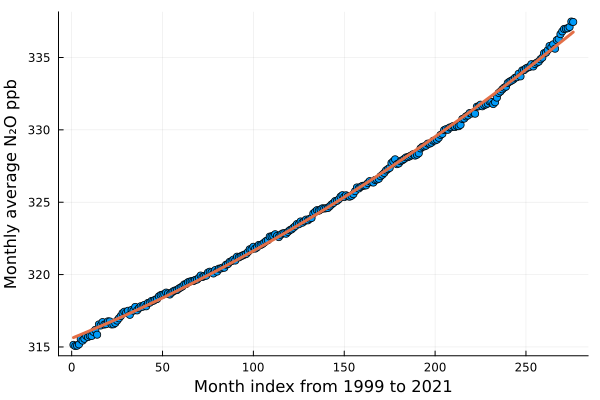

In [3]:
T = nrow(dfg)
t = collect(1:T)
A = [ones(T)  t t.^2]
b = dfg[!, :avgppb];

a =  A \ b
@show(a)

using StatsPlots 

q(t_val) = a[1] + a[2]*t_val + a[3]*t_val^2
@df dfg scatter(:avgppb)
plot!(q, lw=3)
plot!(leg=false, xlab="Month index from 1999 to 2021", ylab="Monthly average N₂O ppb")

## P2. Iterative regularization

In [4]:
import Pkg; Pkg.add("FFTW")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [5]:
using LinearAlgebra, FFTW, Plots, Random

# Generate a signal using 4 random elements from the DCT basis.
function signal(n=200, k=4, ϵ=0.1)
    Random.seed!(19)
    x = zeros(n)
    p = randperm(n)[1:k]
    x[p] .= rand(k)
    noise = ϵ*randn(n)
    s = FFTW.dct(x) # true signal
    b = s + noise   # noisy signal
    return s, b
end

# Create an n-dimensional explicit Discrete Cosine Transform matrix.
function DCT(n::Integer)
    D = zeros(n, n)
    for i in 1:n
        e = zeros(n); e[i] = 1
        D[:,i] = FFTW.dct(e)
    end
    return D
end;

You observe the following noisy 1-D signal, which is stored in the
vector $b$. The true (and “unknown”) signal $s$ is displayed in blue.
(This is a contrived example — in practice, we would not know the true
signal.)

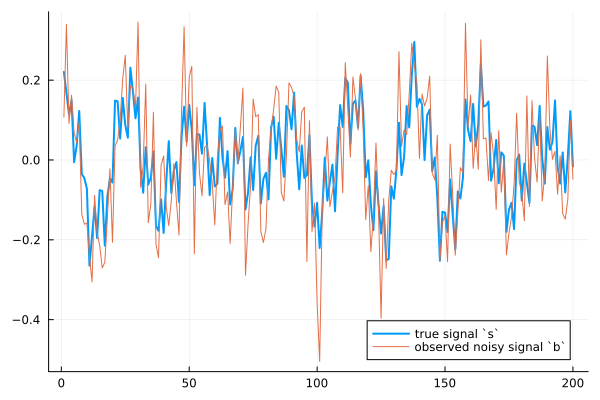

In [6]:
s, b = signal()
plot([s b], w = [2 1], label=["true signal `s`" "observed noisy signal `b`"])

### P2(a) Least-squares solution

Obtain a guess of the underlying signal $s$ by solving a linear
least-squares problem with the DCT matrix $D$ as the basis. Plot the
recovered signal $\bar s$ on top of the true signal $s^\natural$. How
well does the least-squares solution recover the true signal?


In [7]:
#P2a

a_ls = D \ b 
s_ls = D * a_ls

p1 = plot([s b], w = [2 1], label=["True signal s" "Observed noisy b"], 
          title="P2(a): Least Squares", linealpha=[1 0.5])
plot!(p1, s_ls, label="LS Solution (s̄)", ls=:dash, w=2, color=:red)

UndefVarError: UndefVarError: `D` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

**ANS:**
The LS solution does not match the true signal very well as it contains alot of noise.


### P2(b) Iterative regularization

Now suppose that we have knowledge that the signal $s^\natural$ (i.e.,
the signal without noise) is very uniform, and is in fact the
superposition of a few sinusoidal-like elements, such as are contained
in the columns of the [Discrete Cosine
Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform).
Here are the first five columns of the DCT matrix:

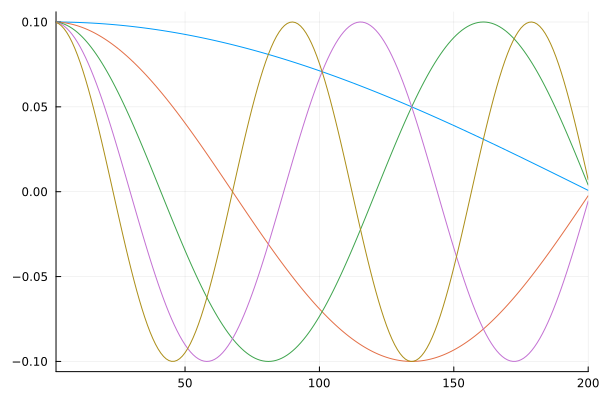

In [8]:
D = DCT(length(b))
plot(D[:, 1:5], xlims=(2, length(b)), leg=false)

The question, then, is how to choose the right columns of $D$ in order
to obtain a good guess of the underlying signal? In other words, is
there a sparse vector $x$ (i.e., one with just a few nonzeros) such that
$$
Dx \approx s?
$$ Equivalently, are there a few columns of $D$ whose span includes the
true signal $s$?

We’ll try to solve this problem by building up a solution $x$ element by
element. We do this by solving a sequence of least-squares problems of
increasing column dimension. The procedure begins with a trivial
solution $x_0 = 0$, associated residual $r_0 = b$, and an empty set of
columns $S_0 = [\ ]$. At each iteration $k>1$ of the procedure, we do
the following:

1.  Find the column of $D$ that is most correlated with the current
    residual $r_k$, i.e., find the index $j_0$ of the column
    $s_k := D[:, j_k]$ that maximizes 
    $$
    \max_j\ |s_k^T r_k|.
    $$
2.  Stop if the correlation is small, i.e., if $|s_k^T r_k| < \tau$ for
    some threshold $\tau$.
3.  Append that column to the current set of columns to obtain
    $S_{k} = [\, \text{new col} \mid S_{k-1}\,]$.
4.  Obtain the next coefficient approximation $x_{k+1}$ and
    corresponding residual $r_{k+1}$ as the solution of the
    least-squares problem 
    $$
    x_{k+1} := \arg\min_x\ \tfrac12\|S_k x - b\|^2.
    $$

Implement this procedure and plot the recovered signal $\hat s$
overlayed on the true signal $s^\natural$. How well does the iterative
regularization procedure recover the true signal? How many iterations
are required to obtain a good approximation?


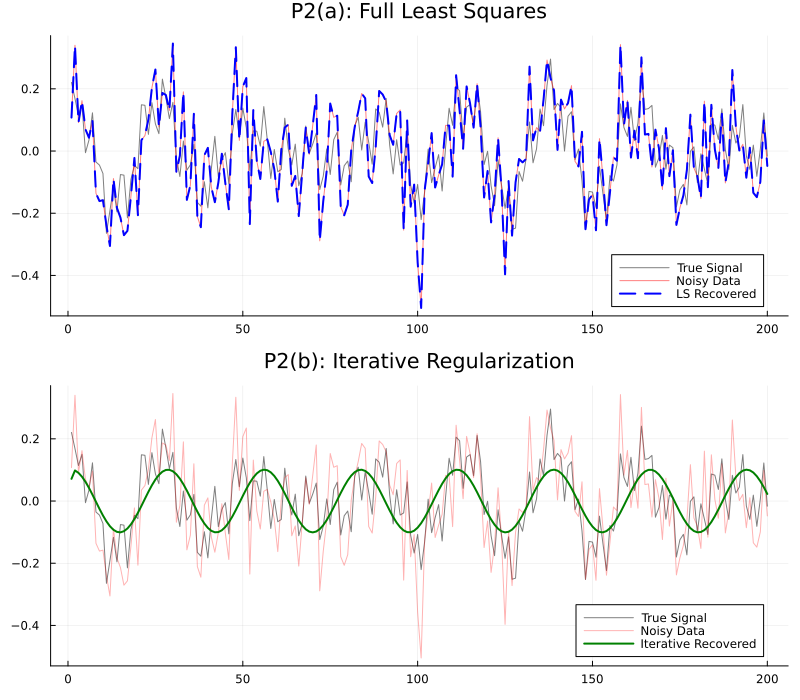

In [9]:
# Noisy LS solution
x_full = D \ b
s_p2a = D * x_full

# Signal threshold
threshold = 1.0  

r = copy(b)       
active_cols = Int[] 
s_p2b = zeros(length(b))    

# iterative solution s_p2b
for k in 1:10
    correlations = D' * r
    j_best = argmax(abs.(correlations))
    max_corr = abs(correlations[j_best])
    
    if max_corr <threshold 
        break
    end
    
    if j_best in active_cols
        break 
    end
    push!(active_cols, j_best)
    
    S_k = D[:, active_cols]
    
    x_sub = S_k \ b
    
    s_p2b = S_k * x_sub
    r = b - s_p2b
end

p1 = plot([s b], label=["True Signal" "Noisy Data"], 
    lc=[:black :red], la=[0.5 0.5], title="P2(a): Full Least Squares")
plot!(p1, s_p2a, label="LS Recovered", ls=:dash, lc=:blue, lw=2)

p2 = plot([s b], label=["True Signal" "Noisy Data"], 
    lc=[:black :red], la=[0.5 0.3], title="P2(b): Iterative Regularization")
plot!(p2, s_p2b, label="Iterative Recovered", lc=:green, lw=2)

plot(p1, p2, layout=(2,1), size=(800, 700))

## P3. Underdetermined systems

Show how to use the QR factorization to solve a full-rank
underdetermined system $Ax=b$ (i.e., $A$ is $m\times n$ with $m<n$ and
$\mathrm{rank}(A)=m$). Give an explicit procedure for solving this
system using the QR factors. Your procedure must only use matrix-vector
products and triangular solves. (Hint: consider using the thin QR
factorization of $A\T$.)

Demonstrate that your method works on a random $2\times 3$ system. These
functions may be useful:

``` julia
A = randn(m, n) # Gaussian random matrix
x = randn(n)    # and vector
```

In [10]:
m = 2
n=3

A = randn(m, n)
b = randn(m)

# Step 1 Compute the Thin QR decomposition of A'
F = qr(A') 
Q = Matrix(F.Q)
R = F.R

# Let Q^Tx = z, then R^Tz = b => z = R^Tb
z = R' \ b

# Then x = Qz 
x = Q * z

res = norm(A*x - b)
@show(res)

res = 5.551115123125783e-16


5.551115123125783e-16

## P4. (Beck 3.1) Tikhonov regularization

Fix the matrices $A\in\R^{m\times n}$ and $L\in\R^{n\times n}$. Consider
the regularized least-squares problem 
$$
\min_x\ \|Ax-b\|^2 + \|Lx\|^2.
$$ 
Show that this problem has a unique solution if and only if
$\Null(A)\cap\Null(L) = \{0\}$.

The objective function $\min_x ||Ax-b||^2 + ||Lx||^2$ can be represented as
$$
\min_x \left|\left| \begin{bmatrix} Ax - b \\ Lx \end{bmatrix} \right| \right|^2 = \min_x \left|\left| \begin{bmatrix} A \\ L \end{bmatrix} x - \begin{bmatrix} b \\ 0 \end{bmatrix} \right|\right|^2
$$
Thus, let
$$
\bar{A} =\begin{bmatrix} A \\ L \end{bmatrix}, \quad \bar{b} = \begin{bmatrix} b \\ 0 \end{bmatrix} 
$$
therefore the optimization problem becomes
$$
\min_x ||\bar{A}x - \bar{b}||^2
$$
which we know has a unique solution if and only if $A$ has full column rank. If a matrix has full column rank then it also means that the only solution to $Ax=0$ is $x=0$ that is
$$
Null(\bar{A}) = \{0\}
$$
If a vector $k$ is in the null space of $\bar{A}$ then
$$
\bar{A}k = \begin{bmatrix} A \\ L \end{bmatrix} k = \begin{bmatrix} Ak \\ Lk \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix} \implies \begin{cases} Ak = 0 \implies k \in null(A) \\ Lk = 0 \implies L \in null(L) \end{cases}
$$ 
and therefore
$$
\{0\} = null(\bar{A}) = null(A) \cap null(L)
$$

## P5. SVD and least-squares

The [Longley
dataset](https://www.itl.nist.gov/div898/strd/lls/data/Longley.shtml) is
a macroenomic dataset used extensively to evaluate the accuracy of
least-squares methods. It comprises 16 observations of 7 economic
variables recorded over the years 1947–1962.

In [11]:
using RDatasets, DataFrames
longley = dataset("datasets", "longley")
first(longley, 5)

Row,Year,GNPDeflator,GNP,Unemployed,ArmedForces,Population,Year_1,Employed
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1947,83.0,234.289,235.6,159.0,107.608,1947,60.323
2,1948,88.5,259.426,232.5,145.6,108.632,1948,61.122
3,1949,88.2,258.054,368.2,161.6,109.773,1949,60.171
4,1950,89.5,284.599,335.1,165.0,110.929,1950,61.187
5,1951,96.2,328.975,209.9,309.9,112.075,1951,63.221


Extract predictor variables and add an intercept column, and extract the
right-hand side:

In [12]:
A = hcat(ones(size(longley, 1)), longley[:, Not(:Employed)])|> Matrix
b = longley.Employed |> Vector

16-element Vector{Float64}:
 60.323
 61.122
 60.171
 61.187
 63.221
 63.639
 64.989
 63.761
 66.019
 67.857
 68.169
 66.513
 68.655
 69.564
 69.331
 70.551

1.  Try to solve the least-squares problem using the QR decomposition.
    You’ll see that it will fail because the matrix $A$ is
    rank-deficient.
2.  Solve the least-squares problem using the SVD. You should remove any
    singular values that are below a certain threshold. A typical
    approach is to remove any singular value 
    $$
    \sigma_i < \varepsilon \max_{ij}A_{ij},
    $$ where $\varepsilon$ is machine precision (e.g., `eps()` in
    Julia).
3.  In both parts (a) and (b), verify that the solution is indeed a
    least-squares solution by checking that the optimality condition
    $$
    \|A^T r\| < \varepsilon\|b\|
    $$ 
    is satisfied, where $r = b - Ax$ is the residual. Good practice
    is to make consider a relative tolerance, say,

$$
\|A^T r\| < 10^{-8}\max(1,\|b\|).
$$

In [13]:
# 1. QR of A 
try
    Q_fac, R_fac = qr(A)

    x_qr = R_fac \ (Q_fac' * b)

    res_qr = b-A*x_qr
    opt_qr = norm(res_qr)
catch e 
    println("$e")
end

# 2. SVD approach
F = svd(A)

U = F.U 
sigma = F.S 
V = F.V

threshold = eps(Float64) * maximum(abs.(A)) 

sigma_filter = [ s > threshold ? 1/s : 0 for s in sigma]

x_SVD = V * Diagonal(sigma_filter) * U' * b 

# 3. Check

res_svd = b - A*x_SVD
opt_svd = norm(A' * res_svd)

println("SVD solution meets threshold: $(opt_svd < 1e-8 * max(1, norm(b)))")

DimensionMismatch("B has first dimension 16 but needs 8")
SVD solution meets threshold: true


## P6. Singular values (Reichel)

Define the matrix $A$ with entries 
$$
a_{ij} = \sqrt{1-x_i^2 - y_j^2}, \quad x_i = y_i = -0.7+\Delta(i-1),\ \Delta=10^{-3}
$$ where $i,j=1,2,\ldots,1401$.

1.  Plot the matrix $A$ in 3D.
2.  Plot the first 50 singular values of $A$.
3.  Plot the error matrix $|A - A_k|$ (interpreted componentwise) where
    $A_k$ is the best rank-$k$ approximation to $A$. Choose $k$ to be
    the index of the largest singular value below $10^{-10}$. You may
    try a surface or contour plot.

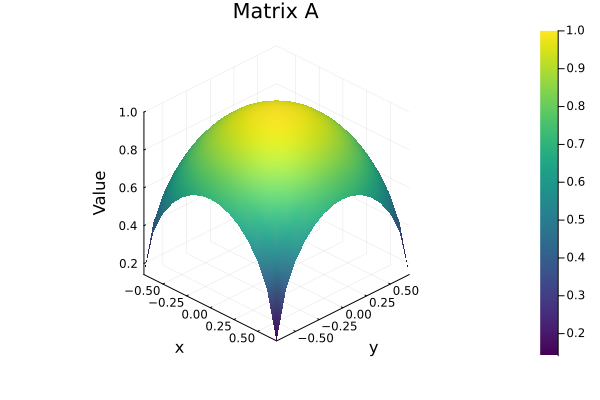

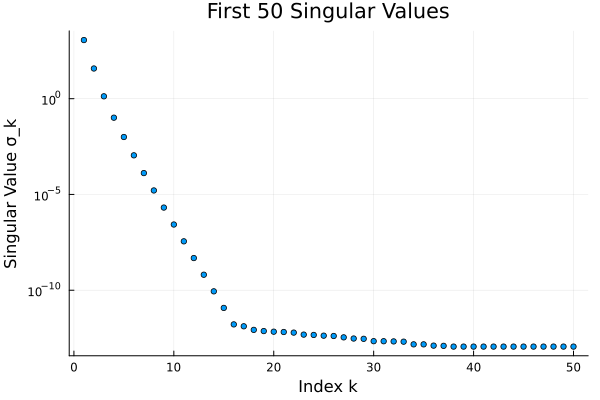

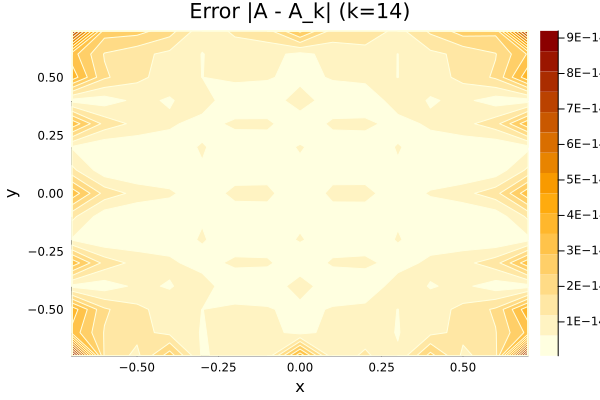

In [14]:
n = 1401
nabla = 1e-3

v = [-0.7 + nabla*(i-1) for i in 1:n]
x = y = v

A = [sqrt(max(0.0, 1 - xi^2 - yj^2)) for xi in x, yj in y]

# 1. 3D Plot of A 
stride = 100
p1 = surface(x[1:stride:end], y[1:stride:end], A[1:stride:end, 1:stride:end],
    title="Matrix A",
    xlabel="x", ylabel="y", zlabel="Value",
    camera=(45, 30), color=:viridis
)
display(p1)

# 2. First 50 Singular Values of A 
F = svd(A)
sigma = F.S 

p2 = scatter(1:50, sigma[1:50], 
    title="First 50 Singular Values",
    xlabel="Index k", ylabel="Singular Value σ_k",
    yscale=:log10, legend=false, markersize=3
)
display(p2)

# 3. Plot of the Error Matrix 
idx_cutoff = findfirst(val -> val < 1e-10, sigma)

if isnothing(idx_cutoff)
    k = 50
else
    k = idx_cutoff 
end

U_k = F.U[:, 1:k]
S_k = Diagonal(sigma[1:k])
V_k = F.V[:, 1:k]
A_k = U_k * S_k * V_k'

E = abs.(A .- A_k)

p3 = contour(x[1:stride:end], y[1:stride:end], E[1:stride:end, 1:stride:end],
    title="Error |A - A_k| (k=$k)",
    xlabel="x", ylabel="y",
    fill=true, color=:heat
)
display(p3)